# Merge mean activations and generate activation gradient plots

Merge the activations for each neuron and each image in a single DataFrame, then for each neuron select the top 5 images producing the largest mean activation. Iterate over all the neurons and calculate the gradient for the selected 5 images and save those as a separate image.

In [3]:
import tensorflow as tf
import vgg16
import utils
import os
import pandas as pd
from pathlib2 import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from __future__ import print_function
import psutil
from tensorflow.python.ops import gen_nn_ops
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
images_root_dir = 'input/tiny-imagenet-200/val/images/'
output_dir = Path('output/')
images_output_dir = 'output_images_deconvrelu/'
custom_gradient_registered = False

# Load all activations

Load the activations for each filter in each layer for all the images.
This could easily be made parallel to speed up execution.

In [ ]:
df_list = []
for f in tqdm(list(output_dir.glob("*.csv"))):
    df = pd.read_csv(str(f), header=0, index_col=0)
    df['image'] = df['image'].str.replace(images_root_dir, '')
    df = df.set_index(['image', 'layer', 'filter'])
    df_list.append(df)
    #if len(df_list) > 10:
    #    break
print("Concatenating..")
df = pd.concat(df_list)
del(df_list) # Hey, let's save some RAM for future generations!
print(df.shape)
df.head()

In [4]:
df.to_hdf('all_activations.hdf', 'activations')

# Select the images producing maximal activation for each layer/filter

Based on the data, find the top N images producing the highest mean activation for each layer/filter.
Using the `nlargest` function in groupby/apply in Pandas is rather slow, most likely because the resulting
DataFrame is continuously enlarged. As you can see, simply selecting the `max` value is much faster, likely because Pandas knows in advance the number of result rows, so it can pre-allocate the required memory.

In [5]:
%%time
df_max_activations = df.groupby(level=['layer', 'filter']).max()
#df_max_activations.head()

CPU times: user 6.96 s, sys: 3.51 s, total: 10.5 s
Wall time: 10.5 s


In [6]:
%%time
df_max_n_activations = df.groupby(level=['layer', 'filter']).apply(
    lambda dfx: dfx.reset_index(['layer', 'filter'], drop=True).nlargest(5, 'mean_activation'))
df_max_n_activations.head()

CPU times: user 3min 38s, sys: 8.77 s, total: 3min 47s
Wall time: 3min 47s


In [7]:
%%time
df_min_n_activations = df.groupby(level=['layer', 'filter']).apply(
    lambda dfx: dfx.reset_index(['layer', 'filter'], drop=True).nsmallest(5, 'mean_activation'))
df_min_n_activations.head()

CPU times: user 3min 40s, sys: 7.9 s, total: 3min 48s
Wall time: 3min 48s


In [ ]:
df_max_n_activations.to_csv('max_n_activations.csv')
df_min_n_activations.to_csv('min_n_activations.csv')

# Load previously computed activations

It is enough to perform the merging/groupby once, we can load the results when starting the notebook again.

In [5]:
df_max_n_activations = pd.read_csv('max_n_activations.csv', index_col=[0, 1, 2])
df_min_n_activations = pd.read_csv('min_n_activations.csv', index_col=[0, 1, 2])

In [6]:
df_max_n_activations.head()

mean_activation
layer               filter image                         
vgg/conv1_1/conv1_1 0      val_8712.JPEG     12439.096680
                           val_5256.JPEG     11875.292969
                           val_4187.JPEG     11430.388672
                           val_8539.JPEG     11397.868164
                           val_9449.JPEG     11134.287109

In [15]:
neurons_per_image = df_max_n_activations.groupby(level='image').count().sort_values('mean_activation', ascending=False)
print("{} images were in the top 5 activations of at least one neuron".format(len(neurons_per_image)))
neurons_per_image.head()

5493 images were in the top 5 activations of at least one neuron


,mean_activation
image,
val_8950.JPEG,410
val_5097.JPEG,371
val_159.JPEG,363
val_6511.JPEG,320
val_4187.JPEG,311


# Check that the gradient calculation works as expected

Perform gradient calculation on a single image to see that the results are as expected. I made a mistake here by first generating all the images without using the custom Relu gradient. This resulted in gradient images that were increasingly noisy and difficult to interpret as I moved deeper into the network, so I had to re-generate all images after fixing this.

Registering a custom gradient in Tensorflow is a bit tricky – one thing to keep in mind is that the custom gradient has to be already registered by the time the model is loaded in order to take effect, otherwise it will be silently ignored.

In [5]:
if not custom_gradient_registered:
    # https://www.tensorflow.org/versions/r0.12/api_docs/python/train/gradient_clipping
    @tf.RegisterGradient("GuidedReluGrad")
    def _GuidedReluGrad(op, grad):
        #return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros_like(grad))
        return tf.clip_by_value(gen_nn_ops._relu_grad(grad, op.outputs[0]), 0, float('inf'))
    
    custom_gradient_registered = True

vgg = vgg16.get_vgg_model()
def load_model():    
    tf.reset_default_graph()
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedReluGrad'}):
        tf.import_graph_def(vgg['graph_def'], name='vgg')
        g = tf.get_default_graph()
    
    return g

g = load_model()
layer_names = [op.name for op in g.get_operations()]

x = g.get_tensor_by_name(layer_names[0] + ':0')
output = g.get_tensor_by_name(layer_names[-2] + ':0')

In [10]:
def load_image(img_path):
    img = vgg16.preprocess(plt.imread(img_path)[:, :, 0:3]) # the selection is needed to get rid of the alpha channel
    img_4d = img[np.newaxis]
    return img_4d

def add_no_droupout(feed_dict):
    feed_dict['vgg/dropout_1/random_uniform:0'] = [[1.0] * 4096]
    feed_dict['vgg/dropout/random_uniform:0'] = [[1.0] * 4096]
    return feed_dict

def compute_gradient(input_placeholder, img, layer_name, filter_i):
    layer = g.get_tensor_by_name(layer_name)
    if len(layer.shape) == 4:
        gradient = tf.gradients(tf.reduce_mean(layer[:, :, :, filter_i]), x)[0]
    elif len(layer.shape) == 2:
        gradient = tf.gradients(tf.reduce_mean(layer[:, filter_i]), x)[0]
    else:
        raise Exception("Unrecognized layer shape.")
    res = sess.run(gradient, feed_dict=add_no_droupout({input_placeholder: img}))[0]
    return res

In [7]:
def montage(images):
    img_h = images.shape[2]
    img_w = images.shape[3]

    if len(images.shape) == 5:
        plot_rows = images.shape[0]
        plot_cols = images.shape[1]
        m = np.ones(
            (images.shape[2] * plot_rows + plot_rows + 1,
             images.shape[3] * plot_cols + plot_cols + 1, 3)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(
            images.shape))
    for i in range(plot_rows):
        for j in range(plot_cols):
            this_img = images[i, j]
            m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
              1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

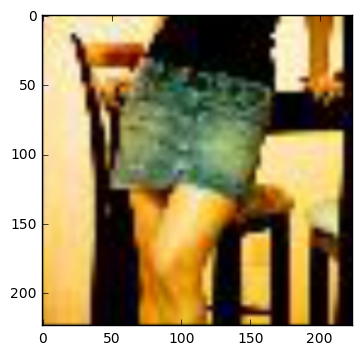

In [8]:
img = load_image(images_root_dir + "val_3008.JPEG")
plt.imshow(img.squeeze())

An image is presented here as a reference of what the results looked like without using the custom gradient for Relu. The objects can be vaguely recognised and separated from the background, but edges and other features can hardly be seen.

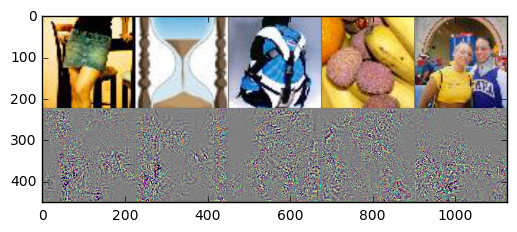

In [10]:
old_image = "output_images/max_act_images_vgg_conv5_1_conv5_1_filter_0.jpg"
plt.imshow(plt.imread(old_image))

The same image, after registering the custom gradients for Relu. This looks exactly like what we want to see - the edges and other object features are clearly recognisable.

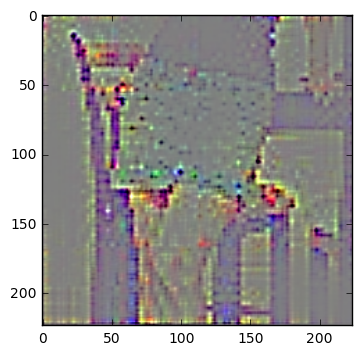

In [ ]:
with tf.Session(graph=g) as sess:
    res = compute_gradient(x, img, 'vgg/conv5_1/conv5_1:0', 0)
res = utils.normalize(res)
plt.imshow(res)

# Calculate the gradient for the selected layer/filter/image combinations

Iterate over each neuron and each image selected in the top 5 images, and calculate the gradient of the activations in the given neuron w.r.t. the image. 

Originally I performed this in a single session, but always calculating a different gradient results in new opeartions being added to the default graph all the time, which makes the calculation slower and slower as the loop progresses. For this reason I had to change this to periodically closing the session and pruning the default graph, to avoid exponential slowdown. This is still a sub-optimal solution, as always reloading the graph and re-creating a session is an unnecessary overhead. There are probably better ways of dealing with this, but I did not have time to explore them, so I sticked with this 'brute-force' approach. 

In [17]:
start_time = time.time()
for layer_name in df_max_n_activations.index.levels[0]:
    print()
    print(layer_name)
    filters_for_layer = df_max_n_activations.loc[layer_name].index.get_level_values(0).unique()
    for filter_num in filters_for_layer:
        print('.', end='')
        #print(psutil.virtual_memory().percent, end=" ")
        #print("%02.2f" % (time.time() - start_time), end=" ")
        start_time = time.time()
        filename = images_output_dir + "max_act_images_{}_filter_{}.jpg".format(
            layer_name.replace('/', '_'), filter_num)
        if os.path.exists(filename):
            continue # Do not spend time generating existing images

        g = load_model()
        layer_names = [op.name for op in g.get_operations()]
        x = g.get_tensor_by_name(layer_names[0] + ':0')

        with tf.Session(graph=g) as sess:

            images_for_filter = df_max_n_activations.loc[layer_name, filter_num].index.get_level_values(0).unique()
            max_act_gradients = []
            max_act_images = []
            for image_name in images_for_filter:
                img = load_image(images_root_dir + image_name)
                max_act_images.append(img.squeeze())

                res = compute_gradient(x, img, layer_name + ':0', filter_num)
                res = utils.normalize(res)
                max_act_gradients.append(res)
            max_act_montage = montage(np.array([np.array(max_act_images), np.array(max_act_gradients)]))

            plt.imsave(arr=max_act_montage, fname=filename)


vgg/conv1_1/conv1_1
................................................................
vgg/conv1_2/conv1_2
................................................................
vgg/conv2_1/conv2_1
................................................................................................................................
vgg/conv2_2/conv2_2
................................................................................................................................
vgg/conv3_1/conv3_1
................................................................................................................................................................................................................................................................
vgg/conv3_2/conv3_2
..........................................................................................................................................................................................................................................